# This notebook is used to check CF calibration performance

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [11]:
def gipps_loss(cfdata, parameters):
    position, speed, time = cfdata[['x_follower','v_follower','time']].values.T

    if np.any(np.isnan(parameters)):
        mae_v = np.nan
    else:
        v_0, s_0, tau, alpha, b, b_leader = parameters
        id_tau = int(tau/0.1)
        
        spacing_hat = np.zeros_like(time) * np.nan
        speed_hat = np.zeros_like(speed) * np.nan
        speed_hat[:id_tau] = speed[:id_tau]
        position_hat = np.zeros_like(position) * np.nan
        position_hat[:id_tau] = position[:id_tau]
        for t in np.arange(0,len(speed_hat)-id_tau,1):
            spacing_hat[t] = cfdata['x_leader'].iloc[t] - position_hat[t]
            v_acc = speed_hat[t] + 2.5*alpha*tau*(1-speed_hat[t]/v_0) * np.sqrt(0.025+speed_hat[t]/v_0)
            braking_spacing = 2*(spacing_hat[t]-s_0)-tau*speed_hat[t]+(cfdata['v_leader'].iloc[t])**2/b_leader
            v_dec = -tau*b + np.sqrt(tau**2*b**2 + b*max(0., braking_spacing))
            speed_hat[t+id_tau] = min(v_acc, v_dec)
            position_hat[t+id_tau] = position_hat[t+id_tau-1] + (speed_hat[t+id_tau-1]+speed_hat[t+id_tau])/2 * (time[t+id_tau]-time[t+id_tau-1])
            
        speed_diff = abs(speed[id_tau:] - speed_hat[id_tau:])
        speed_diff = speed_diff[speed_diff>=0.]
        mae_v = speed_diff.mean()

    return mae_v, time, speed, speed_hat, position, position_hat


def idm_loss(cfdata,parameters):
    position, speed, time = cfdata[['x_follower','v_follower','time']].values.T

    if np.any(np.isnan(parameters)):
        mae_v = np.nan
    else:
        v_0, s_0, T, alpha, beta = parameters
        delta = 4.
        
        s_star = np.zeros_like(time) * np.nan
        acc_hat = np.zeros_like(time) * np.nan
        spacing_hat = np.zeros_like(time) * np.nan
        speed_hat = np.zeros_like(speed) * np.nan
        speed_hat[0] = speed[0]
        position_hat = np.zeros_like(position) * np.nan
        position_hat[0] = position[0]
        for t in np.arange(0,len(speed_hat),3): # operational time interval is 0.3 second
            s_star[t] = s_0 + max(0., speed_hat[t]*T + speed_hat[t]*(speed_hat[t]-cfdata['v_leader'].iloc[t])/2/np.sqrt(alpha*beta))
            spacing_hat[t] = cfdata['x_leader'].iloc[t] - position_hat[t]
            if speed_hat[t]<=0. and spacing_hat[t]<s_0:
                acc_hat[t:t+3] = 0.
            else:
                acc_hat[t:t+3] = alpha * (1 - (speed_hat[t]/v_0)**delta - (s_star[t]/spacing_hat[t])**2)
            speed_hat[t+1:t+4] = speed_hat[t] + acc_hat[t] * (time[t+1:t+4]-time[t])
            speed_hat[speed_hat<0.] = 0.
            position_hat[t+1:t+4] = position_hat[t] + (speed_hat[t]+speed_hat[t+1:t+4])/2 * (time[t+1:t+4]-time[t])

            mae_v = abs(speed[1:] - speed_hat[1:]).mean()
    return mae_v, time, speed, speed_hat, position, position_hat

In [3]:
parent_dir = os.path.abspath('../../../')
data_path = parent_dir + '/Data/OutputData/Variability/'

cfpair = 'HH'
data = pd.read_hdf(data_path+'cfdata_idm_Lyft_'+cfpair+'.h5', key='data')
data = data.sort_values(['case_id','time']).set_index('case_id')

data['dhw'] = data['x_leader'] - data['x_follower']
data['thw'] = data['dhw']/data['v_follower']

idm = pd.read_csv(data_path+'idm/parameters_Lyft_'+cfpair+'.csv', index_col=0)
gipps = pd.read_csv(data_path+'gipps/parameters_Lyft_'+cfpair+'.csv', index_col=0)

In [28]:
case_id = data.index.unique().values[180] # select a case_id
# case_id = 138624
cfdata = data.loc[case_id]
cfdata['x_leader'] = cfdata['x_leader'] - cfdata['x_follower'].min() + 1.
cfdata['x_follower'] = cfdata['x_follower'] - cfdata['x_follower'].min() + 1.
idm_params = idm.loc[case_id].values
gipps_params = gipps.loc[case_id].values
mae_v, time, speed, speed_hat, position, position_hat = gipps_loss(cfdata, gipps_params)
print('CASE ID:', case_id, 'MAE:', mae_v)

CASE ID: 105133 MAE: 0.27082999159294563


mae_v: 0.3294869235934071


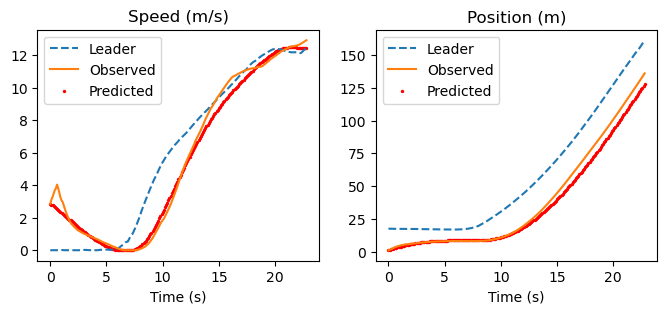

In [29]:
# IDM
mae_v, time, speed, speed_hat, position, position_hat = idm_loss(cfdata, idm_params)
fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].plot(time, cfdata['v_leader'], '--', label='Leader')
axes[0].plot(time, speed, label='Observed')
axes[0].scatter(time, speed_hat, label='Predicted', c='r', s=2)
axes[0].set_xlabel('Time (s)')
axes[0].set_title('Speed (m/s)')
axes[0].legend()
axes[1].plot(time, cfdata['x_leader'], '--', label='Leader')
axes[1].plot(time, cfdata['x_follower'], label='Observed')
axes[1].scatter(time, position_hat, label='Predicted', c='r', s=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Position (m)')
axes[1].legend()
print('mae_v:', mae_v)

mae_v: 0.27082999159294563


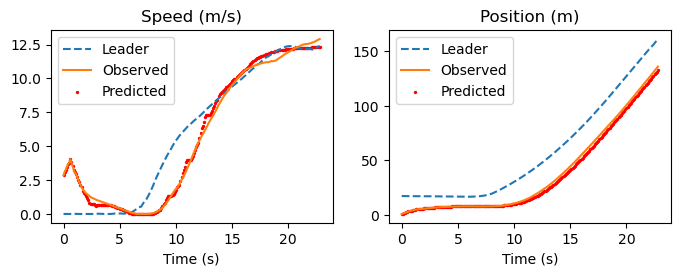

In [30]:
# Gipps
mae_v, time, speed, speed_hat, position, position_hat = gipps_loss(cfdata, gipps_params)
fig, axes = plt.subplots(1,2,figsize=(8,2.5))
axes[0].plot(time, cfdata['v_leader'], '--', label='Leader')
axes[0].plot(time, speed, label='Observed')
axes[0].scatter(time, speed_hat, label='Predicted', c='r', s=2)
axes[0].set_xlabel('Time (s)')
axes[0].set_title('Speed (m/s)')
axes[0].legend()
axes[1].plot(time, cfdata['x_leader'], '--', label='Leader')
axes[1].plot(time, cfdata['x_follower'], label='Observed')
axes[1].scatter(time, position_hat, label='Predicted', c='r', s=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Position (m)')
axes[1].legend()
print('mae_v:', mae_v)